In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from utils.visualize import *
from utils.FIR_filter import *

# ANC + LMS

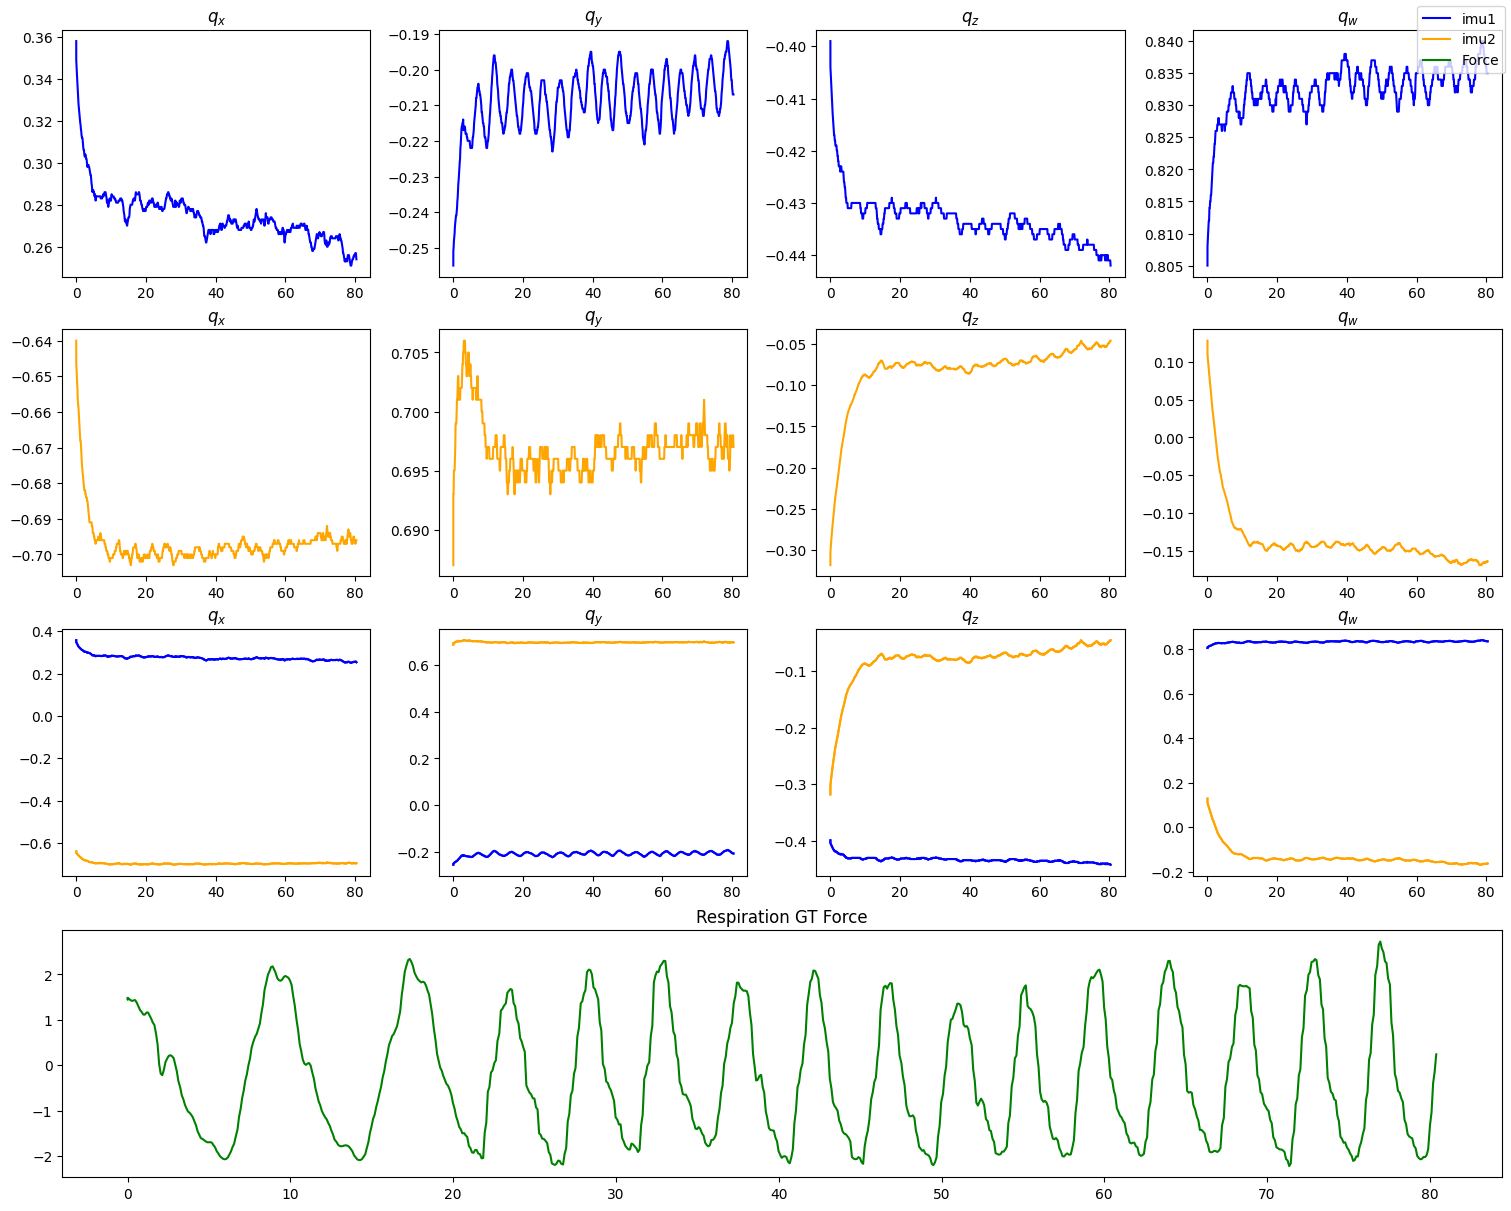

In [2]:
fs = 10
start_pt, end_pt = 50, -50 # 50, -50

file_path = "./data/12_25/stand_2.csv" 

data = pd.read_csv(file_path)
data.columns = [
    "Timestamp",
    "imu1_q_x",
    "imu1_q_y",
    "imu1_q_z",
    "imu1_q_w",
    "imu2_q_x",
    "imu2_q_y",
    "imu2_q_z",
    "imu2_q_w",
    "Force",
    "RR",
]
sensor_names=['imu1','imu2']
cols = ['q_x', 'q_y', 'q_z', 'q_w']
data["Timestamp"] = pd.to_datetime(data["Timestamp"])
data = data.set_index("Timestamp")
data = data.iloc[start_pt:end_pt]

draw_imu_curve(data, overlap=True, show_gt=True)

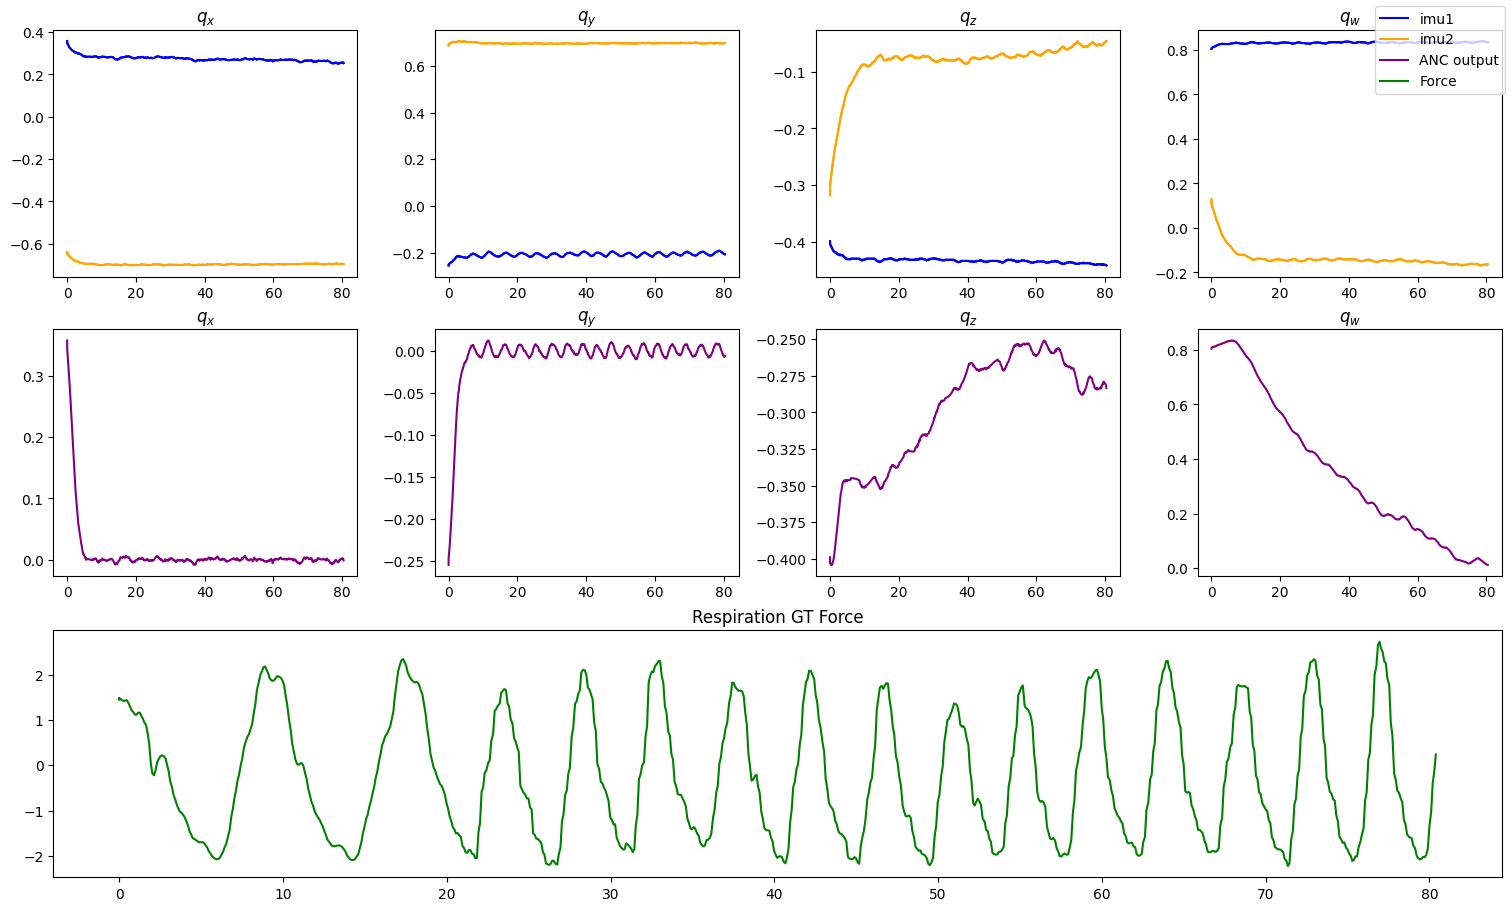

In [3]:
NTAPS = 30 # 10
LEARNING_RATE = 0.005 # 0.001

outputs_dict = {}
for col in cols:
    d = data[sensor_names[0] + '_' + col].to_numpy() # IMU1 (desire signal with more RR info.)
    x = data[sensor_names[1] + '_' + col].to_numpy() # IMU2 (reference noise)
    f = FIR_filter(np.zeros(NTAPS))
    y = np.empty(len(d))
    
    # DO FIR filter + LMS
    for i in range((len(d))):
        ref_noise = x[i]
        canceller = f.filter(ref_noise)
        output_signal = d[i] - canceller
        f.lms(output_signal, LEARNING_RATE)
        y[i] = output_signal
    
    outputs_dict[col] = y

draw_anc_curve(data, outputs=outputs_dict)